In [1]:
import anndata as ad
import scanpy as sc
import episcanpy.api as epi
import anndata as ad
import episcanpy.api as epi
import pandas as pd
import scanpy as sc
import numpy as np
import seaborn as sns
import episcanpy
print(episcanpy.__version__)

/home/icb/anna.danese/.local/lib/python3.7/site-packages/scanpy/api/__init__.py:6: FutureWarning: 

In a future version of Scanpy, `scanpy.api` will be removed.
Simply use `import scanpy as sc` and `import scanpy.external as sce` instead.

  FutureWarning


0.1.6+59.g830cd8d


In [ ]:
DATADIR = ''
result_file = 'processed_all_buenrostro_bulk_peaks.h5ad'

# key parameters
nb_of_features = 150000
target_sum=None
min_cells =10

In [2]:
adata = ad.read(DATADIR+'all_buenrostro_bulk_peaks.h5ad')
adata

# Load metadata
# load annotations and format cell names
adata.obs['original_cell_names'] = adata.obs_names.tolist()

# format cell_names
tmp_cell_names = []
for cell_names in adata.obs_names.tolist():
    cell_names = cell_names.split('/')[-1]
    cell_names = cell_names.rstrip('.dedup.st.bam')
    tmp_cell_names.append(cell_names)
adata.obs['cell_names'] = tmp_cell_names   
adata.obs_names = tmp_cell_names

# I had to add a name for the cell label column. --> first line now read like this 'label\tcell_type\n'
# instead of this 'label\n' originally
epi.pp.load_metadata(adata,
                     metadata_file=DATADIR+'metadata.tsv',
                     path='',
                     separator='\t')

adata.obs['label'] = [n[:-1] for n in adata.obs['label\n']]
del adata.obs['label\n']

print(adata)

# settings for the plots
sc.set_figure_params(scanpy=True, dpi=80, dpi_save=250,
                     frameon=True, vector_friendly=True,
                     color_map="YlGnBu", format='pdf', transparent=False,
                     ipython_format='png2x')




AnnData object with n_obs × n_vars = 2034 × 491436 
    obs: 'batch', 'original_file_name', 'cell_name', 'original_cell_names', 'cell_names', 'label'


# Quality controls and Preliminary data processing

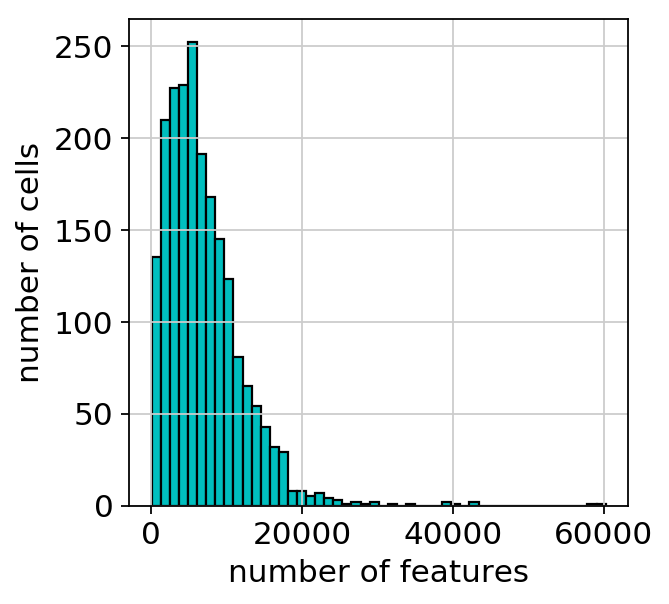

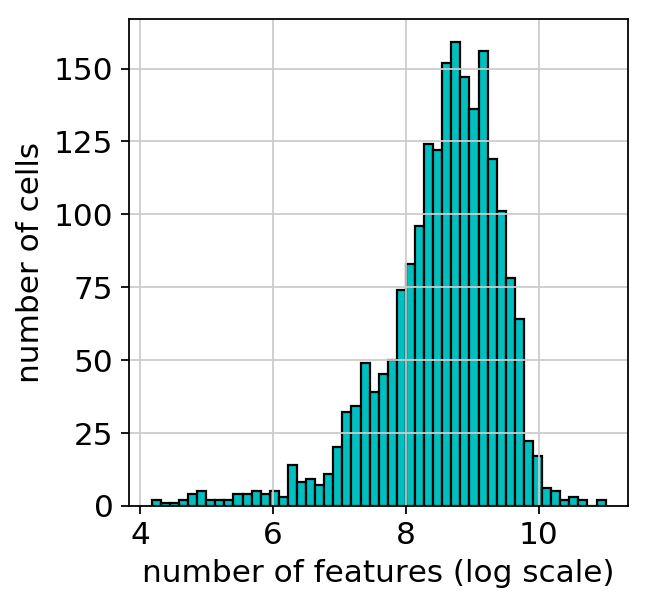

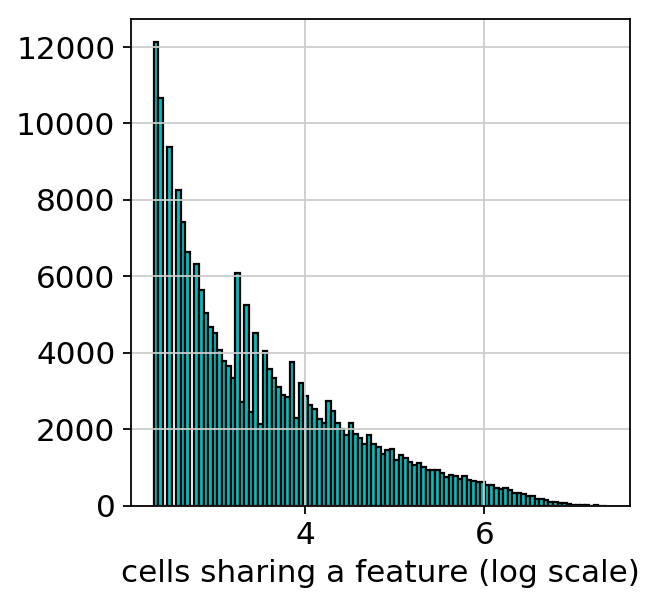

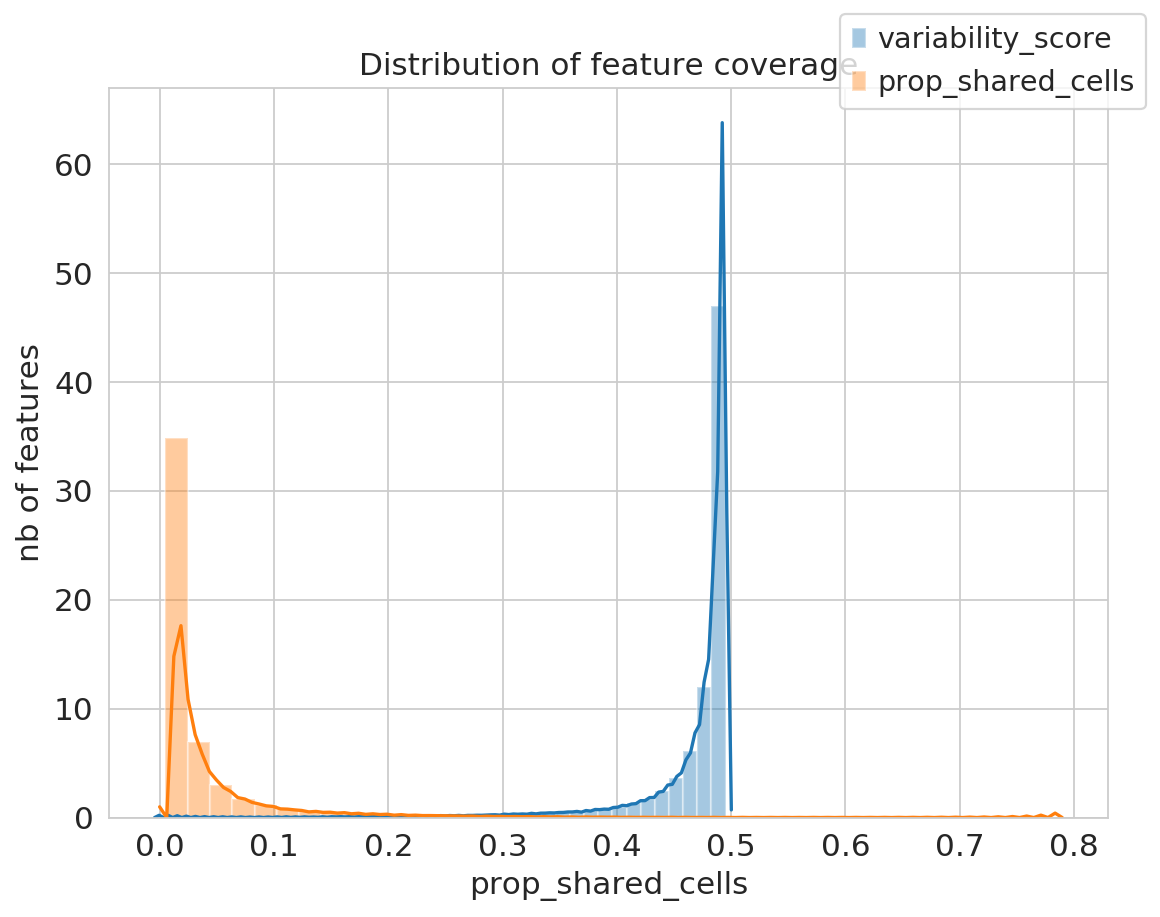

Trying to set attribute `.var` of view, making a copy.


View of AnnData object with n_obs × n_vars = 2034 × 150429 
    obs: 'batch', 'original_file_name', 'cell_name', 'original_cell_names', 'cell_names', 'label', 'n_features', 'nb_features'
    var: 'n_cells', 'commonness', 'prop_shared_cells', 'variability_score'


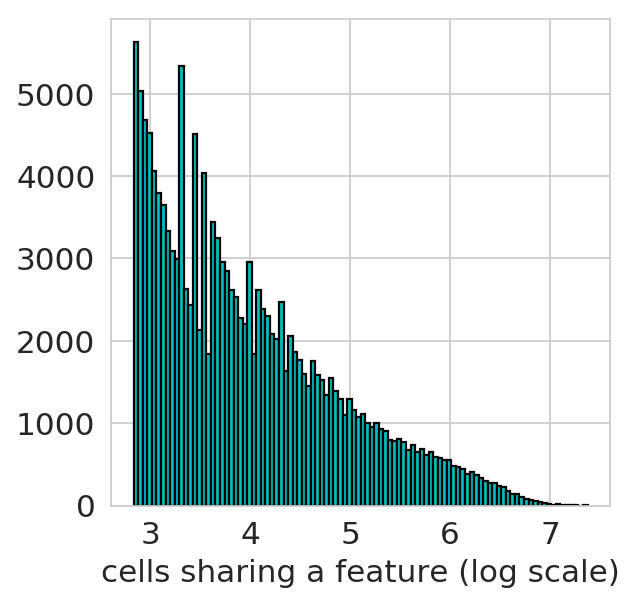

In [4]:
### remove empty cells and empty features
epi.pp.filter_cells(adata, min_features=1)
epi.pp.filter_features(adata, min_cells=min_cells)

epi.pp.coverage_cells(adata, binary=True, log=False)
epi.pp.coverage_cells(adata, binary=True, log=True)

epi.pp.commonness_features(adata, binary=True, log=True)
adatareduced = epi.pp.select_var_feature(adata, nb_features=nb_of_features, copy=True)
print(adatareduced)

epi.pp.commonness_features(adatareduced, binary=True, log=True)

### Normalisation

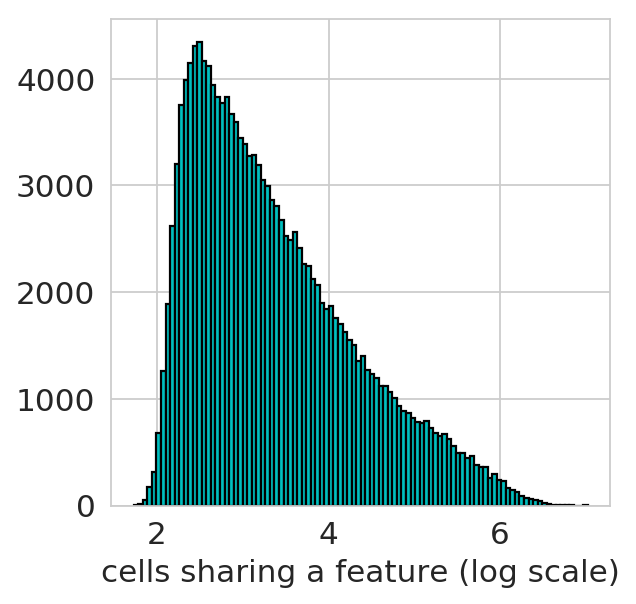

AnnData object with n_obs × n_vars = 2034 × 150429 
    obs: 'batch', 'original_file_name', 'cell_name', 'original_cell_names', 'cell_names', 'label', 'n_features', 'nb_features'
    var: 'n_cells', 'commonness', 'prop_shared_cells', 'variability_score'

In [5]:
epi.pp.normalize_total(adatareduced, target_sum=target_sum, exclude_highly_expressed=False,
 max_fraction=0.05, key_added=None, layers=None, layer_norm=None, inplace=True)
epi.pp.log1p(adatareduced)

epi.pp.commonness_features(adatareduced, binary=True, log=True)
adatareduced

# Embedding

In [7]:
epi.pp.pca(adatareduced, n_comps=100, svd_solver='arpack')
epi.pp.neighbors(adatareduced, n_neighbors=15)
epi.tl.umap(adatareduced)
epi.tl.tsne(adatareduced)
epi.tl.louvain(adatareduced)

# Visualisation

... storing 'label' as categorical


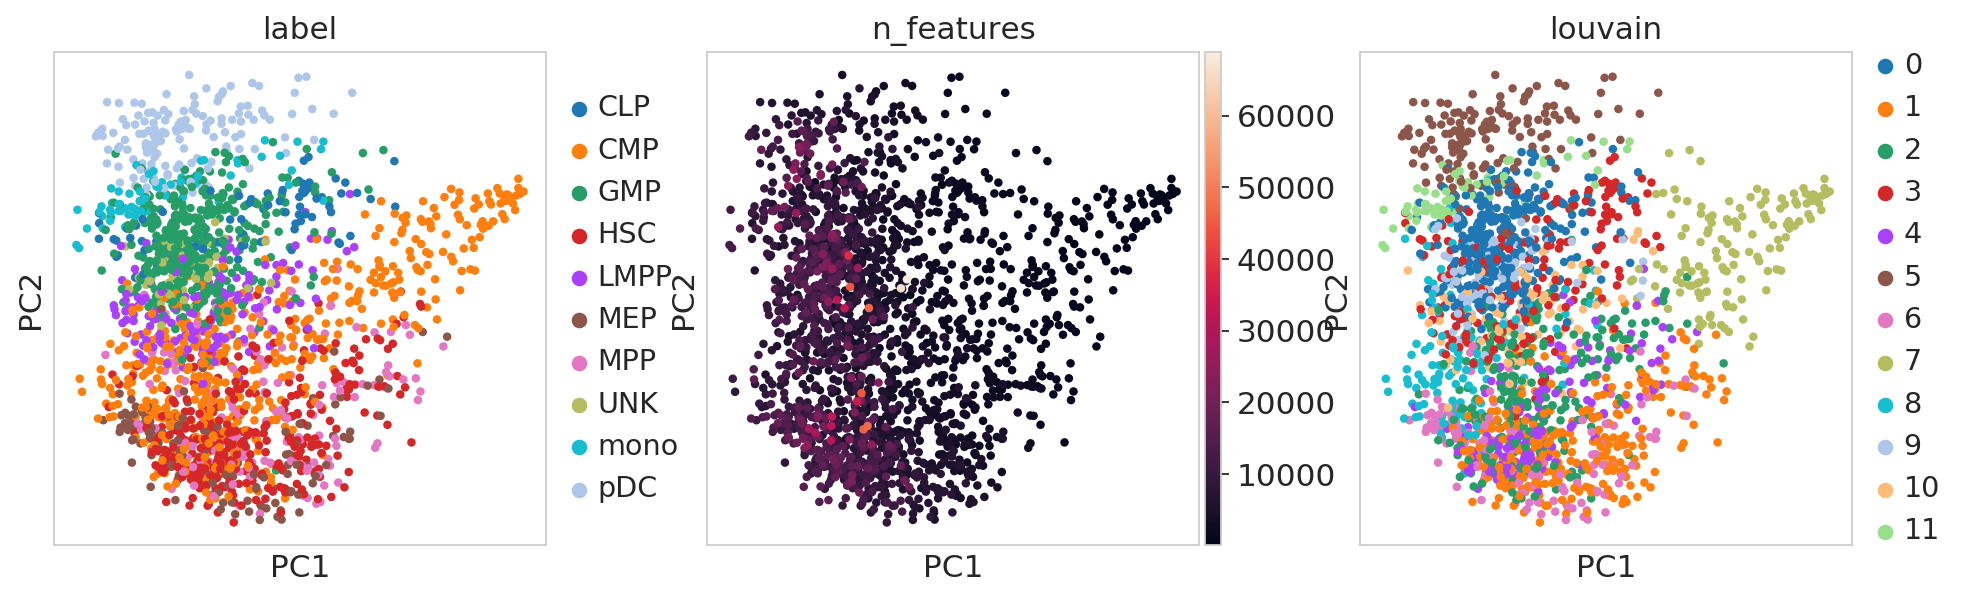

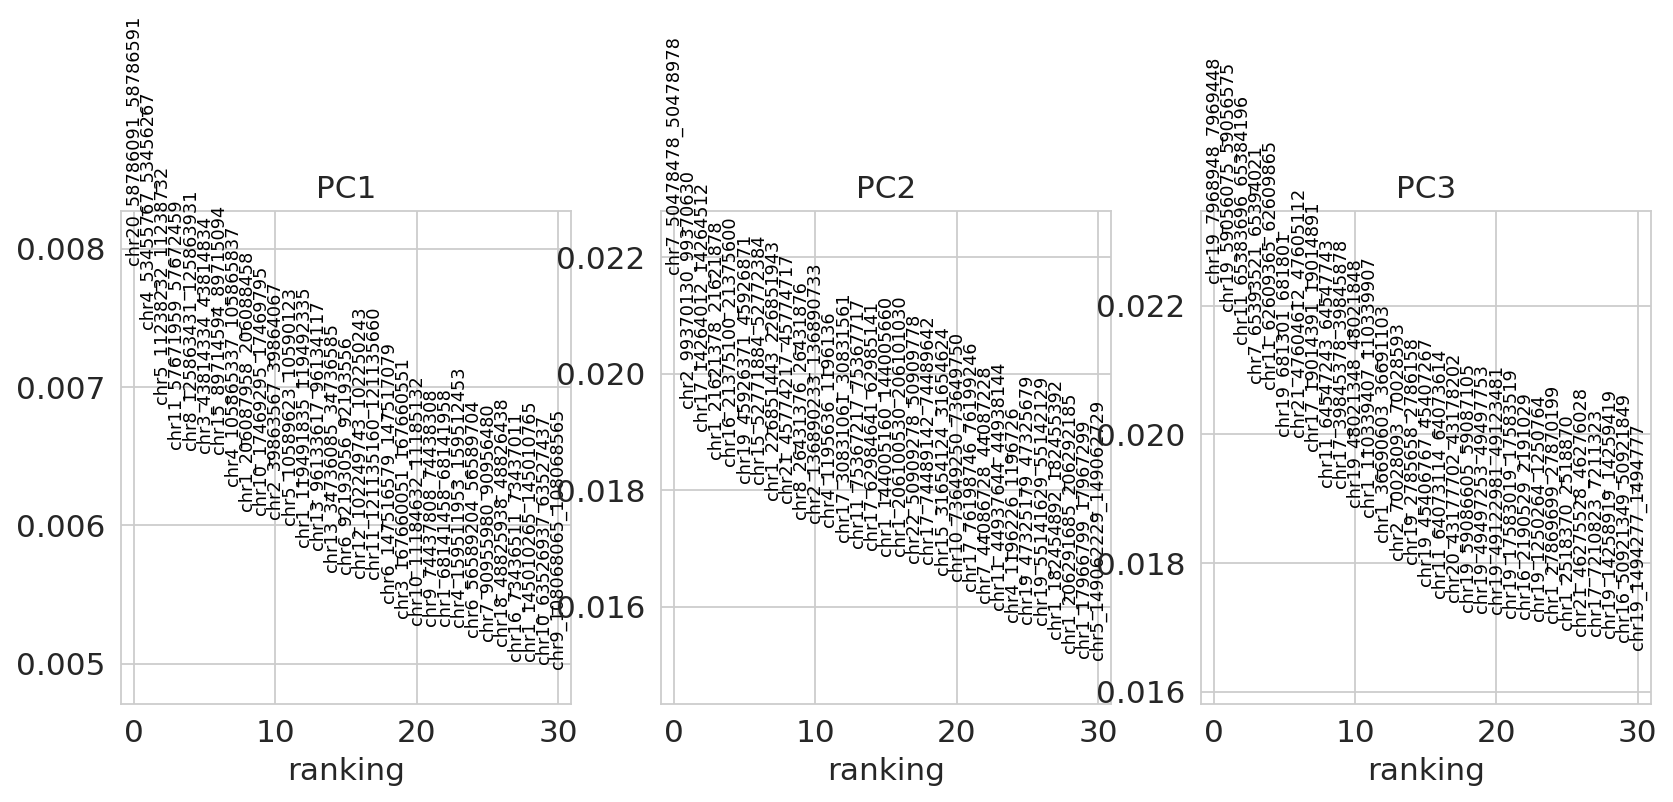

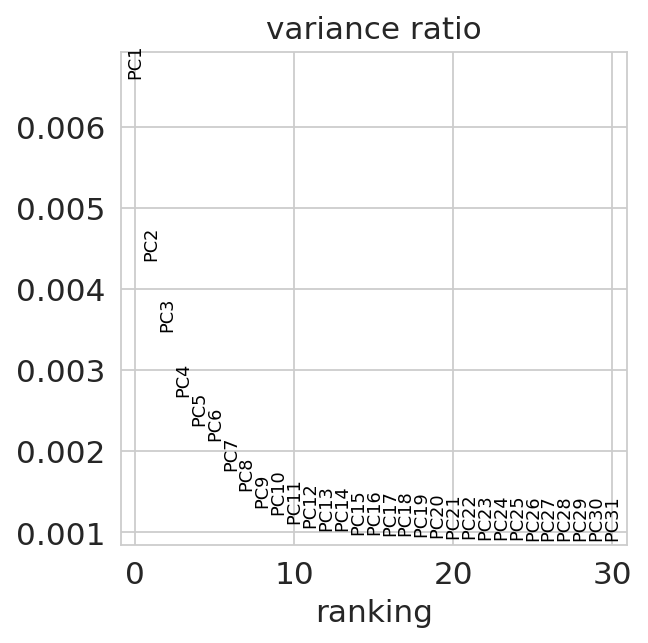

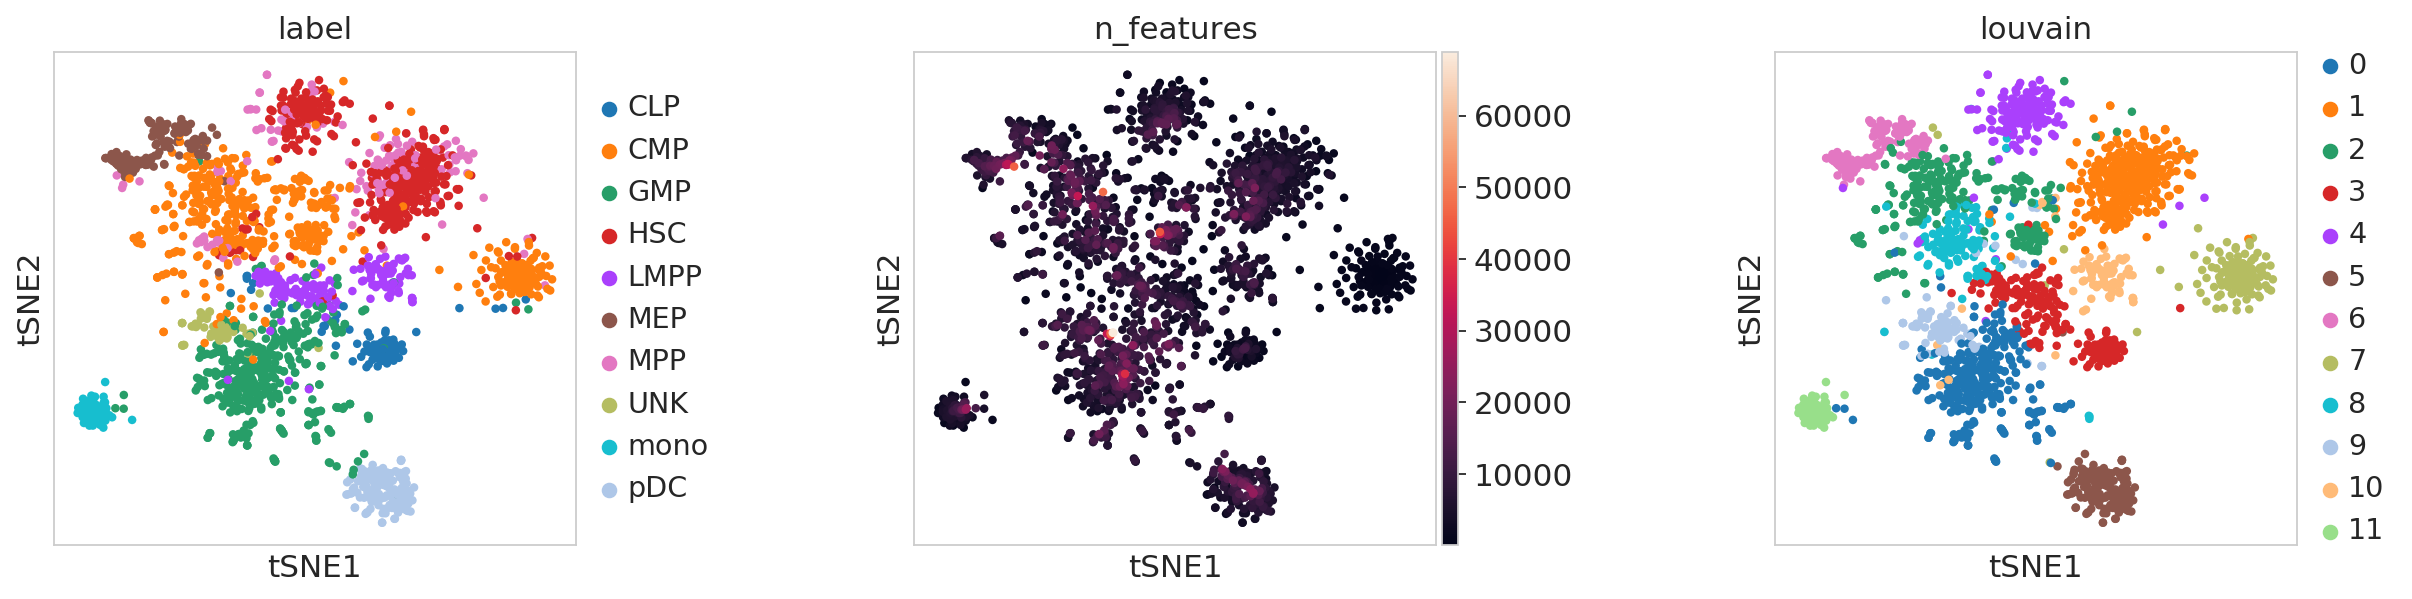

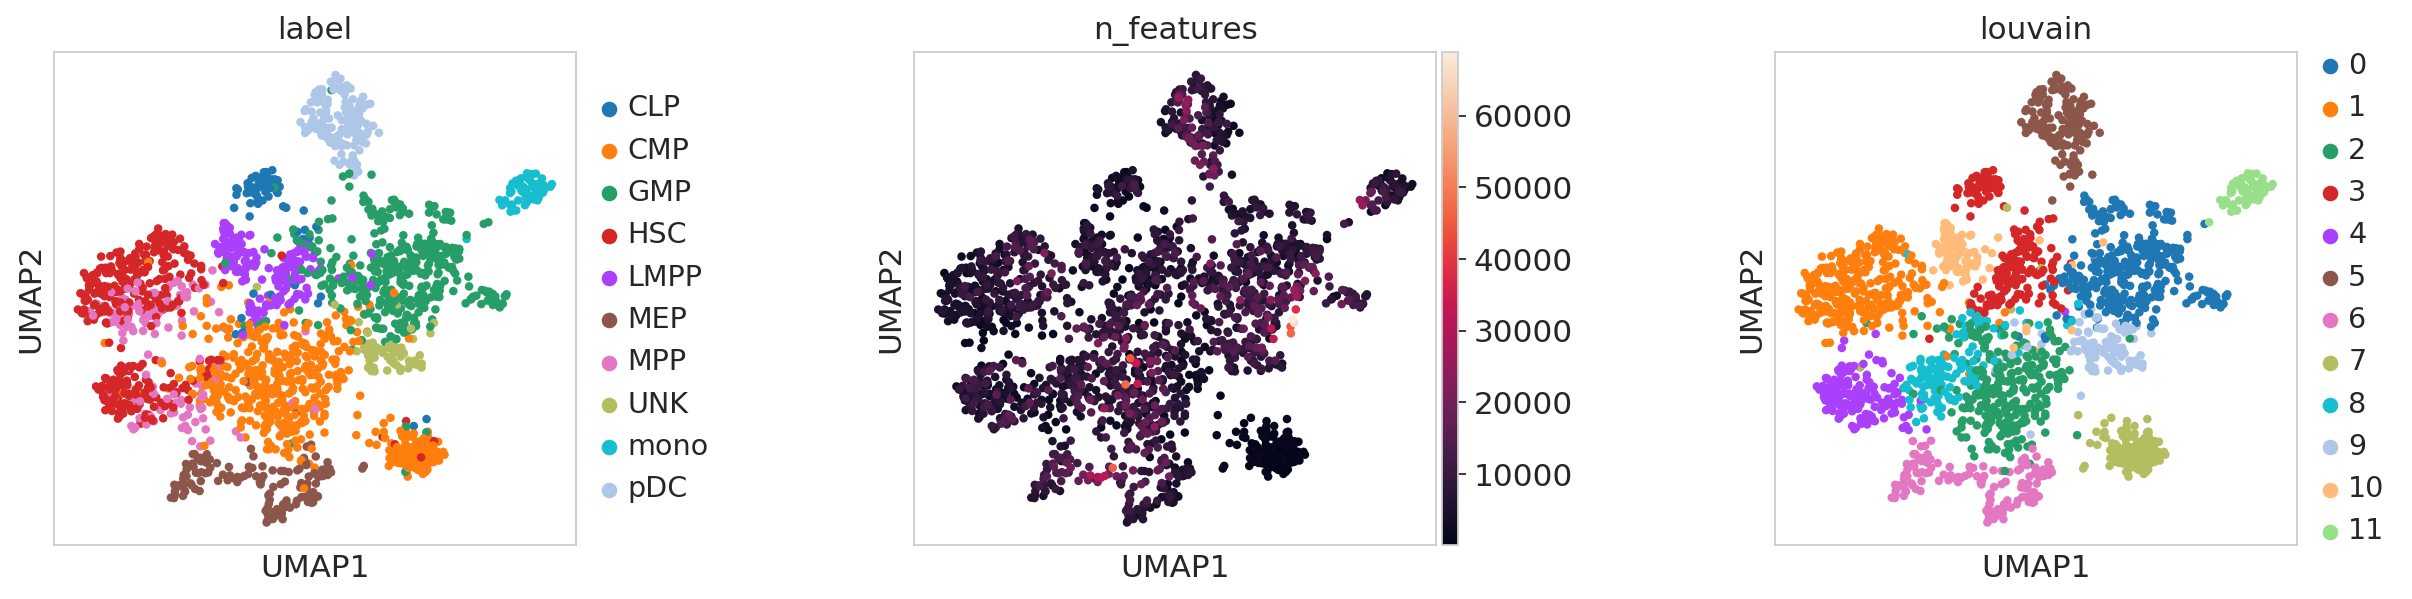

In [8]:
sc.pl.pca_overview(adatareduced, color=['label', 'n_features', 'louvain'])
#sc.pl.pca(adatareduced, color=['label', 'n_features', 'louvain'], wspace=0.5)
sc.pl.tsne(adatareduced, color=['label', 'n_features', 'louvain'], wspace=0.5)
sc.pl.umap(adatareduced, color=['label', 'n_features', 'louvain'], wspace=0.5)

In [ ]:
adatareduced.write(DATADIR+result_file)